In [ ]:
!pip install wordcloud

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer


# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# sklearn
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

# wordCloud
from wordcloud import WordCloud

# pickle
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Class Creation

In [ ]:
class DataUnderstanding():
    """Class that gives the data understanding of a dataset"""
    def __init__(self, data='None'):
        """Initialisation"""
        self.df = data

    def load_data(self, path):
        """Loading the data"""
        if self.df == 'None':
            self.df = pd.read_csv(path, encoding='latin-1')
        return self.df

    def understanding(self):
        # Info
        print("""INFO""")
        print("-"*4)
        self.df.info()

        # Shape
        print("""\n\nSHAPE""")
        print("-"*5)
        print(f"Records in dataset are {self.df.shape[0]} with {self.df.shape[1]} columns.")

        # Columns
        print("\n\nCOLUMNS")
        print("-"*6)
        print(f"Columns in the dataset are:")
        for idx in self.df.columns:
            print(f"- {idx}")

        # Unique Values
        print("\n\nUNIQUE VALUES")
        print("-"*12)
        for col in self.df.columns:
            print(f"Column *{col}* has {self.df[col].nunique()} unique values")
            if self.df[col].nunique() < 12:
                print(f"Top unique values in the *{col}* include:")
                for idx in self.df[col].value_counts().index:
                    print(f"- {idx}")
            print("")

        # Missing or Null Values
        print("""\nMISSING VALUES""")
        print("-"*15)
        for col in self.df.columns:
            print(f"Column *{col}* has {self.df[col].isnull().sum()} missing values.")

        # Duplicate Values
        print("""\n\nDUPLICATE VALUES""")
        print("-"*16)
        print(f"The dataset has {self.df.duplicated().sum()} duplicated records.")

Loading the dataset

In [ ]:
# Load the dataset
data = DataUnderstanding()
df = data.load_data(path="judge-1377884607_tweet_product_company.csv")
# First five rows of dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [ ]:
data.understanding()

INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


SHAPE
-----
Records in dataset are 9093 with 3 columns.


COLUMNS
------
Columns in the dataset are:
- tweet_text
- emotion_in_tweet_is_directed_at
- is_there_an_emotion_directed_at_a_brand_or_product


UNIQUE VALUES
------------
Column *tweet_text* has 9065 unique values

Column *emotion_in_tweet_is_directed_at* has 9 unique values
Top unique values in the *emotion_in_tweet_is_directed_at* include:
- iPad
- Apple
- iPad or iPhone App
-

# Data cleaning

## Validity

Corrupted Records in the *tweet_text Column*
The data seems to be corrupted in some records. To correct this issue, we create a function that can find these corrupted records, and returns their indexes. We use this index to remove the record from the working dataframe.

In [ ]:
# A function targeting corrupted records
def is_corrupted(tweet):
    """This func returns the index of any record that is corrupted"""
    corrupted_cols = []
    for key, text in enumerate(tweet):
        if any(ord(char) > 127 for char in str(text)) == True:
            corrupted_cols.append(key)
    return corrupted_cols

In [ ]:
# Applying the is_corrupted function to find the indexes of the corrupted records
corrupted_records_idx = is_corrupted(df['tweet_text'])

In [ ]:
# Test to check if the function worked as intended
df.loc[corrupted_records_idx]['tweet_text'].values[0]

'@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW'

In [ ]:
# Drop these records
df.drop(index=corrupted_records_idx, inplace=True)

In [ ]:
# Test to ensure there are no corrupted records left
is_corrupted(df['tweet_text'])

[]

#### ***Drop Records in the *is_there_an_emotion_directed_at_a_brand_or_product* column where the value is "I can't tell"***

In [ ]:
# Identification of the record
bad_reaction_idx = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"].index

# Drop the columns
df.drop(index = bad_reaction_idx, inplace=True)

# Test
df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


#### ***Replace Fields in the *is_there_an_emotion_directed_at_a_brand_or_product* column where the value is "No emotion toward brand or product" to "Neutral emotion"***

In [ ]:
# Identification of the record
neutral_reaction_idx = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] ==\
                              "No emotion toward brand or product"].index

# Replace the values
df.loc[neutral_reaction_idx, 'is_there_an_emotion_directed_at_a_brand_or_product'] = "Neutral emotion"

# Test
df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


### ***Completeness***

#### ***Drop Missing Values in the *tweet_text* column***

In [ ]:
tweet_missing = df[df['tweet_text'].isnull() == True].index
df.loc[tweet_missing]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,Neutral emotion


In [ ]:
# Drop the record
df.drop(index=tweet_missing, inplace=True)

In [ ]:
# Check
df[df['tweet_text'].isnull() == True]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


#### ***Fill Missing Values in the *emotion_in_tweet_is_directed_at* column***

In [ ]:
# Find the records with missing values in the 2nd column
df[df['emotion_in_tweet_is_directed_at'].isnull() == True].shape[0]

5331

In [ ]:
# List of unique products/ services
products = list(df.emotion_in_tweet_is_directed_at.unique())
products.remove(np.nan) # Removes any np.nan items

def find_product(tweet):
    """This func takes in a tweet and returns the product talked about in the
    tweet; used to fill in the emotion_in_tweet_is_directed_at column"""
    for product in products:
        if str(product) in tweet or str(product).upper() in tweet \
            or  str(product).lower() in tweet or str(product).title() in tweet:
            return product

# Applying the function to find the index of records with missing values in the 2nd column
missing_products_idx = df[df['emotion_in_tweet_is_directed_at'].isnull() == True].index

In [ ]:
# Replace the field where there are missing values in the emotion_in_tweet_is_directed_at column
df.loc[missing_products_idx, 'emotion_in_tweet_is_directed_at'] = df.loc[missing_products_idx, 'tweet_text']\
                                                                        .apply(lambda x: find_product(x))

In [ ]:
# In case any field was not captured by our function, we can change it to 'None'
none_index = df[df['emotion_in_tweet_is_directed_at'].isnull()].index
df.loc[none_index, 'emotion_in_tweet_is_directed_at'] = 'None'
# df.loc[none_index]

In [ ]:
# Check
df['emotion_in_tweet_is_directed_at'].value_counts()

,count
emotion_in_tweet_is_directed_at,
iPad,2273
Google,1984
Apple,1269
iPhone,1093
None,720
iPad or iPhone App,448
Android,284
Other Google product or service,278
Android App,77


In [ ]:
# Number of values in the column are the same as the length of the data
np.sum(df['emotion_in_tweet_is_directed_at'].value_counts().values) == df.shape[0]

True

# Drop the duplicates

In [ ]:
# Dropping the duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Check if there is any remaining duplicate values
df.duplicated().sum()

0

## Renaming the columns

In [ ]:
# Change the column names
df.rename(columns={'tweet_text': "tweet",
                  'emotion_in_tweet_is_directed_at':"product",
                  'is_there_an_emotion_directed_at_a_brand_or_product': "emotion"},
         inplace=True)

In [ ]:
# Check
df.columns

Index(['tweet', 'product', 'emotion'], dtype='object')

#### ***Reset the Index of the dataframe***

In [ ]:
# Reset the index
df.reset_index(inplace=True)
# Drop the old index column
df.drop(labels='index', axis=1, inplace=True)
df

,tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8434,"@mention Yup, but I don't have a third app yet...",Android,Neutral emotion
8435,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8436,"Wave, buzz... RT @mention We interrupt your re...",Google,Neutral emotion
8437,"Google's Zeiger, a physician never reported po...",Google,Neutral emotion


In [ ]:
DataUnderstanding(data=df).understanding()

INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439 entries, 0 to 8438
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8439 non-null   object
 1   product  8439 non-null   object
 2   emotion  8439 non-null   object
dtypes: object(3)
memory usage: 197.9+ KB


SHAPE
-----
Records in dataset are 8439 with 3 columns.


COLUMNS
------
Columns in the dataset are:
- tweet
- product
- emotion


UNIQUE VALUES
------------
Column *tweet* has 8434 unique values

Column *product* has 10 unique values
Top unique values in the *product* include:
- iPad
- Google
- Apple
- iPhone
- None
- iPad or iPhone App
- Android
- Other Google product or service
- Android App
- Other Apple product or service

Column *emotion* has 3 unique values
Top unique values in the *emotion* include:
- Neutral emotion
- Positive emotion
- Negative emotion


MISSING VALUES
---------------
Column *tweet* has 0 missing values.
Column *product*

### Data Visulisation

In [ ]:
def plot_bar(feature, plot='bar'):
    """This func returns a bar or a barh plot"""
    if plot == 'bar':
        labels = df[feature].value_counts().index
        values = df[feature].value_counts().values
        plt.bar( x=labels,height=values)
        plt.ylabel("Count")
        plt.xlabel("Categories")
    else:
        labels = df[feature].value_counts(ascending=True).index
        values = df[feature].value_counts(ascending=True).values
        plt.barh(width=values, y=labels)
        plt.xlabel("Count")
        plt.ylabel("Categories")
    plt.title(f"Distribution of the {feature.title()} feature");


### ***Distribution of the *emotion* feature***

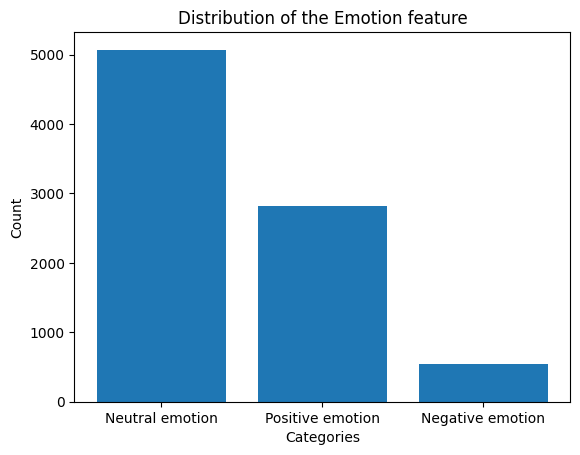

In [ ]:
plot_bar('emotion')

The distribution shows a huge class imbalance between categories. The Neutral Emotion category holds over 50% of the data

### ***Distribution of the *product* feature***

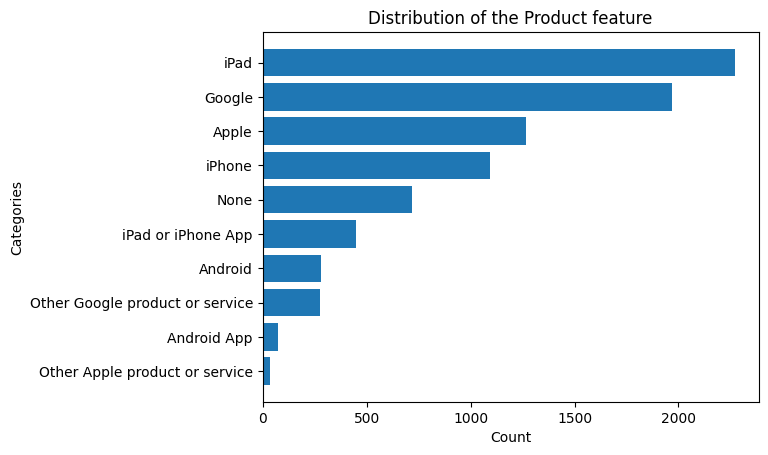

In [ ]:
plot_bar('product', plot='barh')

The data reveals there was a lot of sentiments concerning the iPad in the period, followed closely by the Google and Apple company.

The data has a 'None' category meaning that it did not concern the Apple of Google products originally set out at the start of the project.

## Text Preprocessing

Text Processing includes steps like removing punctuation, tokenization (splitting text into words or phrases), converting text to lowercase, removing stop words (common words that add little value), and stemming or lemmatization (reducing words to their base forms)

In [ ]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english') + ['sxsw', 'sxswi', 'link', 'rt'])
lemmatizer = WordNetLemmatizer()

def lemmatize_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (keep the text after the #)
    text = re.sub(r'#', '', text)
    # Remove special characters like "&quot;"
    text = re.sub(r'&\w+;', '', text)
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize text
    tokens = re.split('\W+', text.lower())
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Remove extra white spaces
    tokens = [word.strip() for word in tokens if word.strip() != '']
    # Remove numbers
    tokens = [word for word in tokens if not word.isdigit()]
    # Tag parts of speech
    pos_tags = nltk.pos_tag(tokens)
    # Filter tokens to retain only nouns, adjectives, verbs, and adverbs
    important_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}
    tokens = [word for word, tag in pos_tags if tag in important_pos]
    return tokens

# Apply the clean_text function to the 'tweet' column
df['lemmatized_tweet'] = df['tweet'].apply(lambda x: lemmatize_tweet(x))

def join_text(tokens):
    """
    This function takes a list of tokens (words) and returns them as a single string.
    Each token is separated by a space.

    Parameters:
    tokens (list of str): A list of tokens to be joined.

    Returns:
    str: The tokens joined into a single string separated by spaces.
    """
    return " ".join(tokens)

df['clean_tweet'] = df['lemmatized_tweet'].apply(lambda x: join_text(x))

# Print the cleaned tweets
df.head()


,tweet,product,emotion,lemmatized_tweet,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[iphone, hr, tweeting, riseaustin, dead, need,...",iphone hr tweeting riseaustin dead need upgrad...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[wait, ipad, also, sale]",wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[great, stuff, fri, mayer, google, tim, oreill...",great stuff fri mayer google tim oreilly tech ...


### ***Visual for Lemmatized Tweets***

In [ ]:
def plot_fdist(sentiment=None, title="Frequency Distribution of All Words", df=df):
    """
    This func creates a Frequency Distribution plot depending on the sentiment chosen
    """

    if sentiment == None:
        lemmatized_tweet = df['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

    elif sentiment != None:
        lemmatized_tweet = df[df['emotion'] == sentiment]['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

    # Create the frequency distribution
    fdist = FreqDist(flattened_lemmatized_tweet)

    # Plot the frequency distribution
    plt.figure(figsize=(10,6))
    plt.title(title, fontsize=14)
    fdist.plot(30);

### ***Frequency Distribution of Lemmatized words***

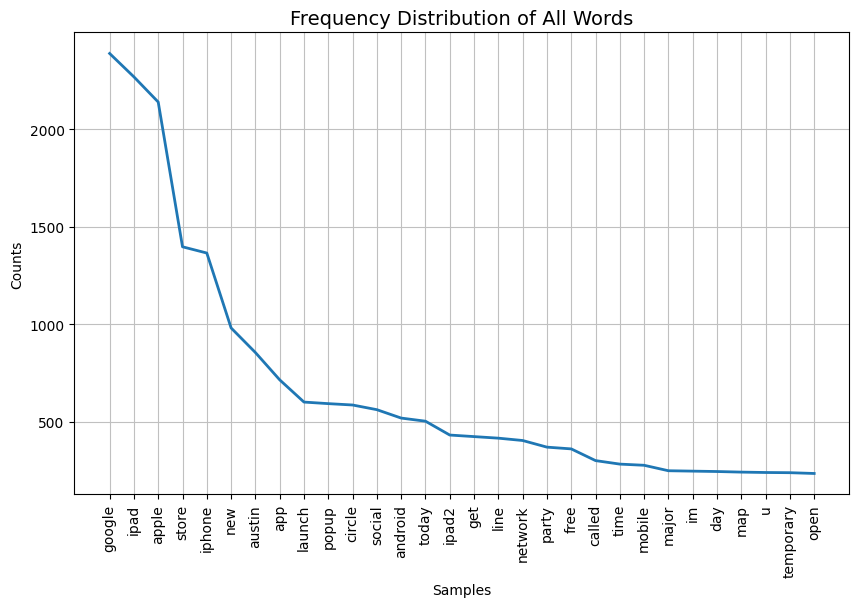

In [ ]:
plot_fdist()

### ***Frequency Distribution of Lemmatized words categorized as Neutral Emotion***

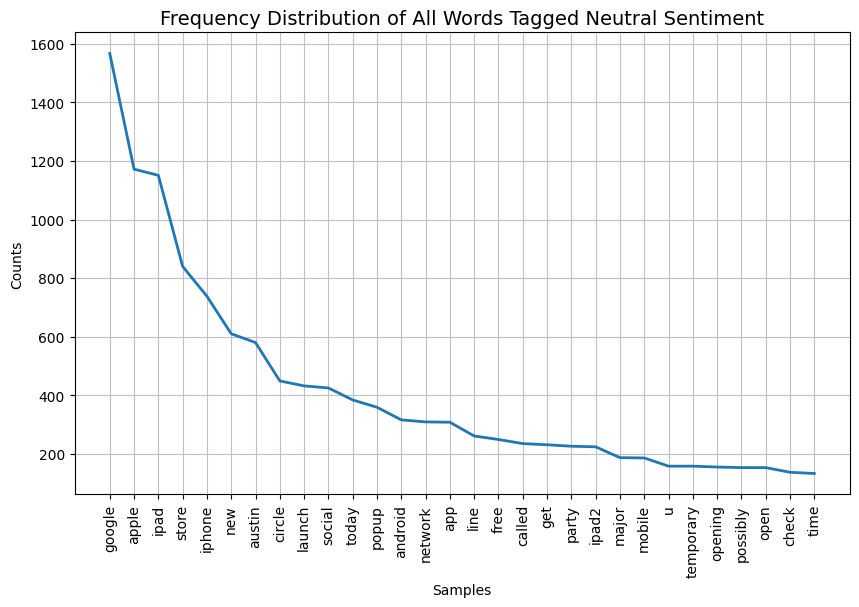

In [ ]:
plot_fdist(sentiment="Neutral emotion", title="Frequency Distribution of All Words Tagged Neutral Sentiment")

with respect to all the data categorised as *'neutral'*, the words 'google', 'apple', 'ipad' and 'store' appeared more frequently than all other words.


### ***Creating Bigrams***

Analyzing bigrams improves context understanding by considering pairs of words together, which helps in understanding phrases that might have specific meanings different from their individual words

In [ ]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# Alias for BigramAssocMeasures
bigram_measures = BigramAssocMeasures()

In [ ]:
def bigram_plots(sentiment=None, title="Bigram of The Data - All Sentiments", df=df, items=20):
    """
    This function returns a horizontal plot of the highest scored bigrams in the dataset
    """
    if sentiment == None:
        lemmatized_tweet = df['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

    elif sentiment != None:
        lemmatized_tweet = df[df['emotion'] == sentiment]['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

    # Create BigramCollocationFinder
    finder = BigramCollocationFinder.from_words(flattened_lemmatized_tweet)

    # Score bigrams by raw frequency
    scored = finder.score_ngrams(bigram_measures.raw_freq)

    # Display the 20 most common bigrams
#     for bigram, score in scored[:20]:
#         print(bigram, score)

    # Order the bigrams
    scores = sorted(scored[:items], key=lambda x: x[1])

    # labels and width
    labels, score = [b[0] + " " + b[1] for b, _ in scores], [score for _, score in scores]

    # Plot
    plt.figure(figsize=(10,6))
    plt.title(title, fontsize=14)
    plt.ylabel("Bigrams")
    plt.xlabel("Scores")
    plt.barh(y=labels, width=score);

#### ***Bigrams - All data***

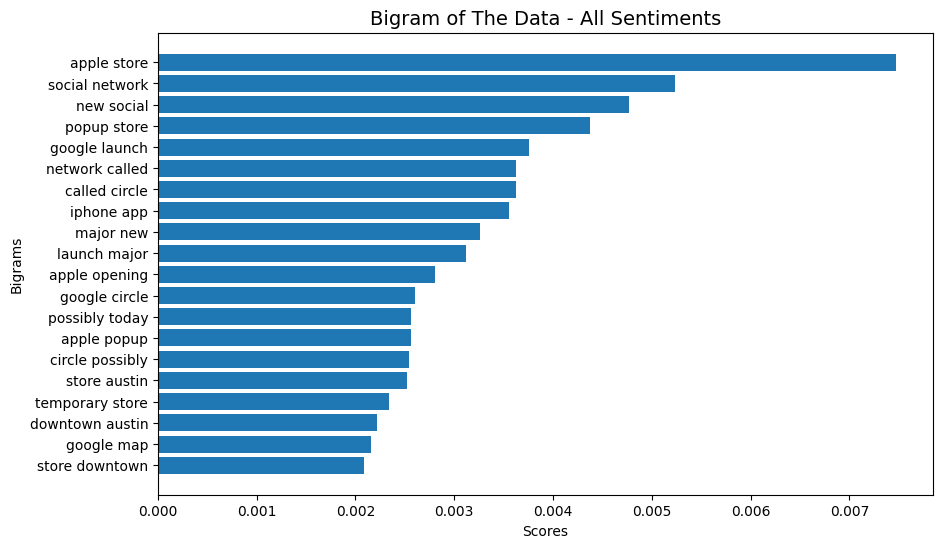

In [ ]:
bigram_plots()

"apple store", "social network" and "new social" had the highest scores with respect to all the data available.

#### ***Bigrams - Neutral data***

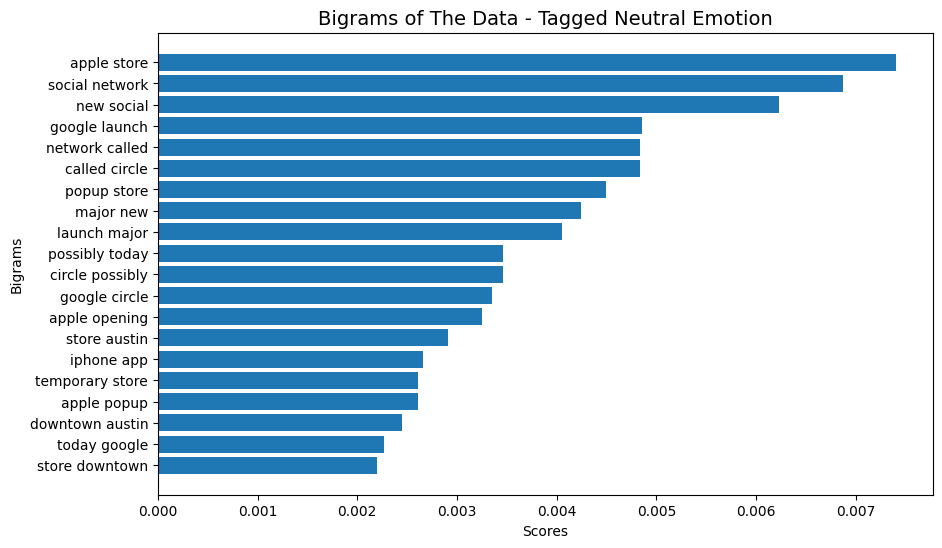

In [ ]:
bigram_plots(sentiment='Neutral emotion', title='Bigrams of The Data - Tagged Neutral Emotion')

"apple store", "social network" and "new social" had the highest scores with respect to all the data categorised as neutral.

Bigrams - Positive data

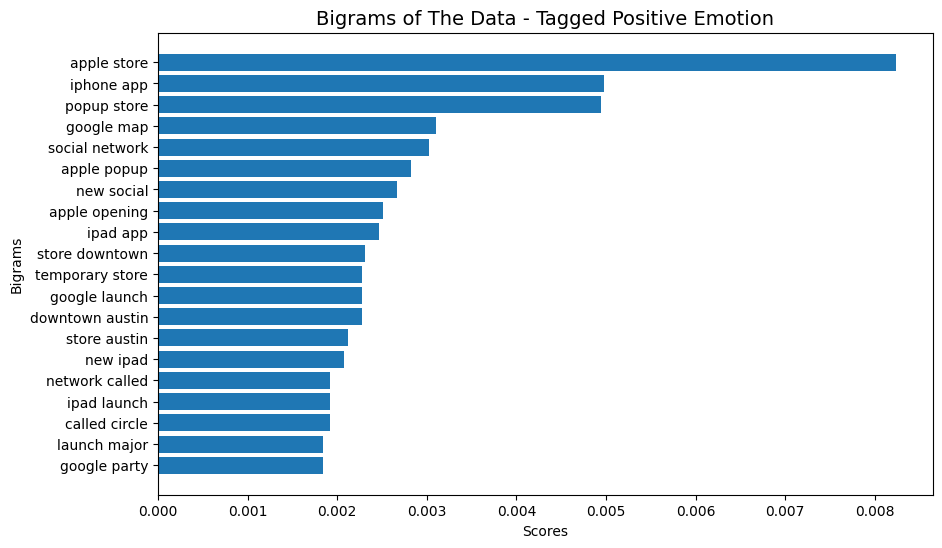

In [ ]:
bigram_plots(sentiment='Positive emotion', title='Bigrams of The Data - Tagged Positive Emotion')

apple store", "iphone app" and "popup store" had the highest scores with respect to all the data categorised as positive.

Bigrams - Negative Emotion

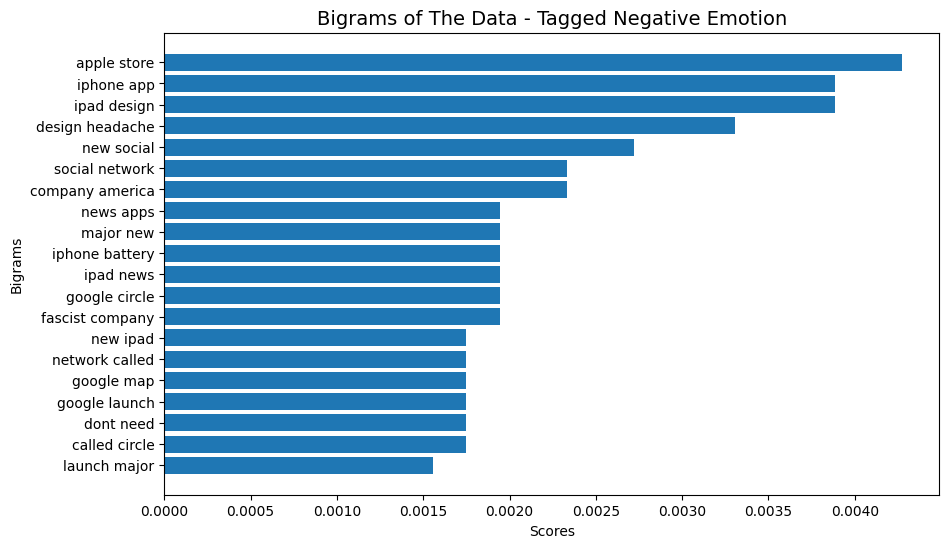

In [ ]:
bigram_plots(sentiment='Negative emotion', title='Bigrams of The Data - Tagged Negative Emotion')

apple store", "iphone app" and "ipad design" had the highest scores with respect to all the data categorised as negative

### ***Word Cloud Visual***

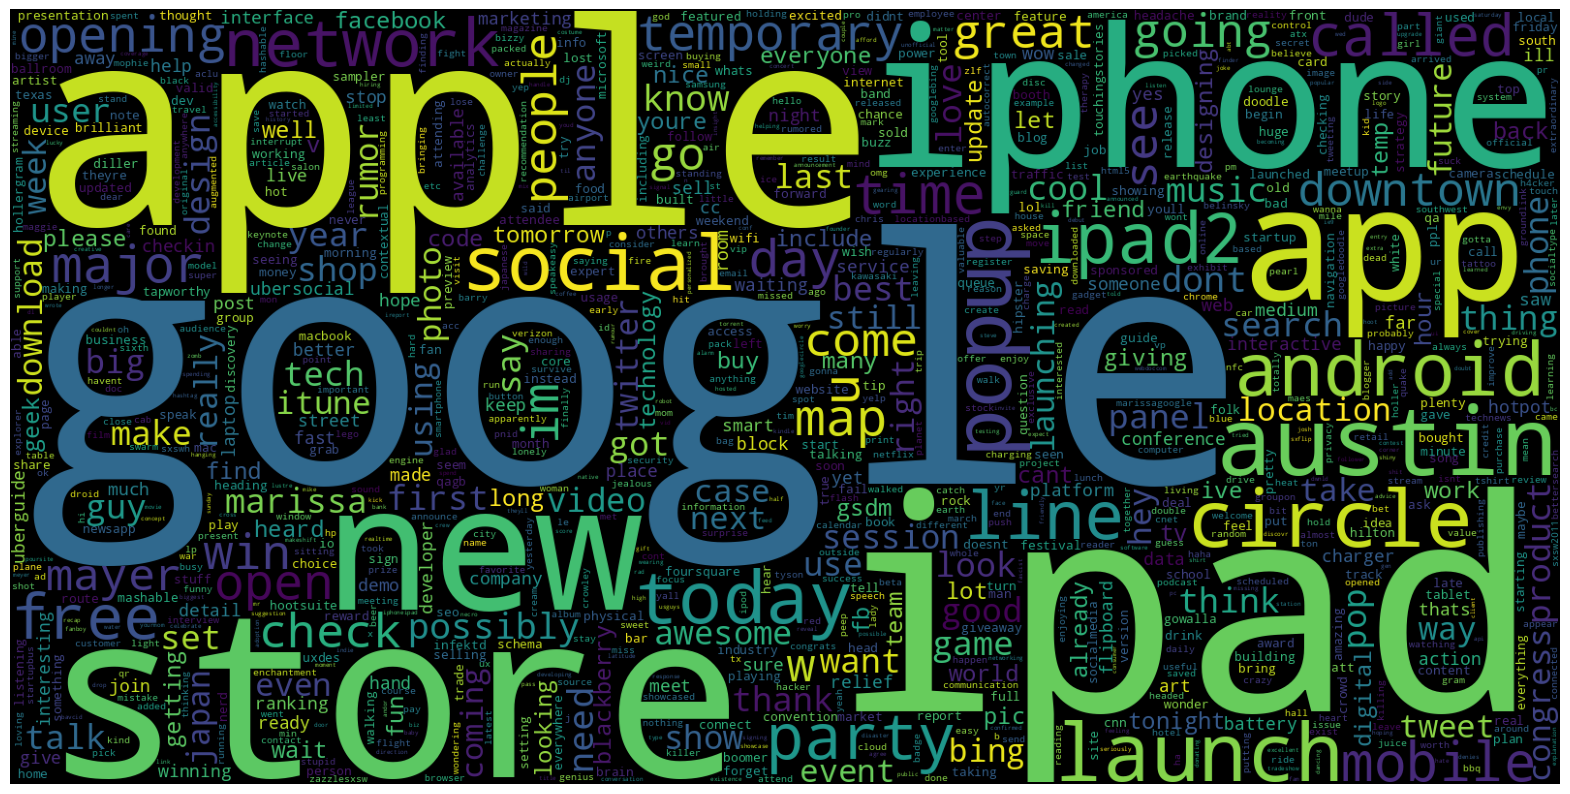

In [ ]:
# !pip install wordcloud

from wordcloud import WordCloud

lemmatized_tweet = df['lemmatized_tweet']

# Flatten the list
flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

# Use all processed text directly
data_neg = flattened_lemmatized_tweet[:len(flattened_lemmatized_tweet)]

# Create the word cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))

# Display the word cloud
plt.imshow(wc)
plt.axis('off')  # Hide axes
plt.show()

### Modeling

### Preprocessing

Prepare data for modeling by:

- **Label Encoding:** Converted emotion labels into numerical values.
- **Vectorization:** Used TF-IDF and CountVectorizer to transform text data into numerical vectors.
- **SMOTE:** Applied SMOTE to handle class imbalance.
- **Train test split:** To split the data

### Label encoding

In [ ]:
# Classify the data
y = df['emotion']

# Label Enconde the target
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(y)
target[:5]

array([0, 2, 2, 0, 2])

In [ ]:
# Confirm labels
label_encoder.classes_

array(['Negative emotion', 'Neutral emotion', 'Positive emotion'],
      dtype=object)

### Vetorization

CountVetorizer

In [ ]:
# Vectorization - CV
cv = CountVectorizer()

X_vec = cv.fit_transform(df['clean_tweet'])
X_vec = pd.DataFrame.sparse.from_spmatrix(X_vec)
X_vec.columns = sorted(cv.vocabulary_)
X_vec.set_index(y.index, inplace=True)
X_vec = X_vec.iloc[:, 160:]

In [ ]:
# SMOTE - CV
smote = SMOTE()
X_cv_smote, y_cv_smote = smote.fit_resample(X_vec, target)



#### ***Train Test split - CV***

In [ ]:
# Train Test and split - CV
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv_smote, y_cv_smote, test_size=0.3, random_state=42)

#### ***TFIDF Vectorization***

In [ ]:
# Vectorization - TFIDF
tf = TfidfVectorizer()

X_tf = tf.fit_transform(df['clean_tweet'])
X_tf = pd.DataFrame.sparse.from_spmatrix(X_tf)
X_tf.columns = sorted(tf.vocabulary_)
X_tf.set_index(y.index, inplace=True)
X_tf = X_tf.iloc[:, 160:]

In [ ]:
# SMOTE - TFIDF
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_tf_smote, y_tf_smote = smote.fit_resample(X_tf, target)

In [ ]:
# Train Test and Split - TFIDF
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf_smote, y_tf_smote, test_size=0.3, random_state=42)

### ***Models***

The machine learning algorithims used in this section are:
- RandomForest
- Naive Bayes(MultinomialNB)
- LogisticRegression
- DecisionTrees

 We will use the split data to predict which model will achieve the highest accuracy and use it for deployment.

In [ ]:
def modelling(model, cv=False, tf=False):
    if cv == True:
        # Fit the instantiated model
        model.fit(X_train_cv, y_train_cv)
        # Predict
        y_hat = model.predict(X_test_cv)
        # Results
        print("Count Vectorisation Results\n")
        print("Main Metrics")
        print("-"*12)
        print(f"Accuracy Score {round(accuracy_score(y_test_cv, y_hat), 3)}")
        # Use 'macro' averaging for multiclass classification
        print(f"Recall Score {round(recall_score(y_test_cv, y_hat, average='macro'), 3)}")
        # Classification Report
        print("\nClassification Report")
        print(classification_report(y_test_cv, y_hat))


    elif tf == True:
        # Fit the instantiated model
        model.fit(X_train_tf, y_train_tf)
        # Predict
        y_hat = model.predict(X_test_tf)
        # Results
        print("---------")
        print("TFIDF Vectorisation Results\n")
        print("Main Metrics")
        print("-"*12)
        print(f"Accuracy Score {round(accuracy_score(y_test_tf, y_hat), 3)}")
        # Use 'macro' averaging for multiclass classification
        print(f"Recall Score {round(recall_score(y_test_tf, y_hat, average='macro'), 3)}")
        # Classification Report
        print("\nClassification Report")
        print(classification_report(y_test_tf, y_hat))

def hyper_tuning(model, params, model_name="Random Forest"):
    """This function optimises the base model with the parameters
    passed as params"""
    # Grid Search Base Model
    grid_search_model = GridSearchCV(model, params, cv=5, scoring='accuracy')
    # Count Vectorisation
    # Perform grid search with 5-fold cross-validation for Count Vectorization
    grid_search_rf_cv = grid_search_model.fit(X_train_cv, y_train_cv)

    # Get the best model from grid search for Count Vectorization
    best_rf_model_cv = grid_search_rf_cv.best_estimator_

    # Predict on the test set using the best model for Count Vectorization
    y_pred_cv = best_rf_model_cv.predict(X_test_cv)

    # Calculate and print the accuracy for Count Vectorization
    accuracy_cv = accuracy_score(y_test_cv, y_pred_cv)

    # Calculate and print the recall for Count Vectorization
    recall_cv = recall_score(y_test_cv, y_pred_cv, average ='macro')

    # Results
    print("Count Vectorisation Results\n")
    print(f"Best {model_name.title()} Model (Count Vectorization):\n", best_rf_model_cv)
    print(f"\nTest Accuracy (Count Vectorization): {accuracy_cv:.3f}")
    print(f"\nTest Recall (Count Vectorization): {recall_cv:.3f}")
    print("---------")

    #TFIDF Vectorisation
    grid_search_rf_tf = grid_search_model.fit(X_train_tf, y_train_tf)

    # Get the best model from grid search for TF-IDF Vectorization
    best_rf_model_tf = grid_search_rf_tf.best_estimator_

    # Predict on the test set using the best model for TF-IDF Vectorization
    y_pred_tf = best_rf_model_tf.predict(X_test_tf)

    # Calculate and print the accuracy for TF-IDF Vectorization
    accuracy_tf = accuracy_score(y_test_tf, y_pred_tf)

    # Calculate and print the reacll for TF-IDF Vectorization
    recall_tf= recall_score(y_test_tf, y_pred_tf, average ='macro')

    # Results
    print("\n\nTFIDF Vectorisation Results\n")
    print(f"Best {model_name.title()} Model (TFIDF Vectorization):\n", best_rf_model_tf)
    print(f"\nTest Accuracy (TFIDF Vectorization): {accuracy_tf:.3f}")
    print(f"\nTest Recall (TFIDF Vectorization): {recall_tf:.3f}")

    # models = [best_rf_model_cv, best_rf_model_tf]

    return best_rf_model_cv, best_rf_model_tf

#### ***Model 1 - Multinomial Bayes - CV Data***

In [ ]:
# Instantiate the multinomialnb model
mnb = MultinomialNB()

In [ ]:
# Classification report of the multinomial using the Count Vectorization
modelling(model=mnb, cv=True)
# Classification report of the multinomial using the TFIDF Vectorization
modelling(model=mnb, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.631
Recall Score 0.63

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1541
           1       0.68      0.58      0.62      1523
           2       0.52      0.61      0.56      1500

    accuracy                           0.63      4564
   macro avg       0.64      0.63      0.63      4564
weighted avg       0.64      0.63      0.63      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.772
Recall Score 0.771

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1541
           1       0.75      0.59      0.66      1523
           2       0.70      0.76      0.73      1500

    accuracy                           0.77      4564
   macro avg       0.77      0.77      0.76      4564
weighted avg       0.77      0.77      0.77     

#### ***Hyperparameter Tuning the MNB Model***

In [ ]:
# params
mnb_param_grid = {
    'alpha': [0.01, 0.1]
}

# GridSearchCV for tuning
tuned_mnb_cv_model, tuned_mnb_tf_model = hyper_tuning(model=mnb, params=mnb_param_grid, model_name="MNB")

Count Vectorisation Results

Best Mnb Model (Count Vectorization):
 MultinomialNB(alpha=0.01)

Test Accuracy (Count Vectorization): 0.654

Test Recall (Count Vectorization): 0.653
---------


TFIDF Vectorisation Results

Best Mnb Model (TFIDF Vectorization):
 MultinomialNB(alpha=0.01)

Test Accuracy (TFIDF Vectorization): 0.798

Test Recall (TFIDF Vectorization): 0.797


 The accuracy score is at 80% which is an improvement from 77%. The models improvement is due to tuning

#### ***Model 2 - Random Forest***

In [ ]:
# Instantiate a random forest model
# Set `n_estimators = 1000` , `max_features = 5` and `max_depth = 5`
rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)

In [ ]:
modelling(model=rf, cv=True)
modelling(model=rf, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.477
Recall Score 0.481

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.16      0.27      1541
           1       0.74      0.38      0.50      1523
           2       0.39      0.90      0.54      1500

    accuracy                           0.48      4564
   macro avg       0.67      0.48      0.44      4564
weighted avg       0.67      0.48      0.44      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.713
Recall Score 0.713

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1541
           1       0.76      0.42      0.55      1523
           2       0.55      0.89      0.68      1500

    accuracy                           0.71      4564
   macro avg       0.76      0.71      0.71      4564
weighted avg       0.77      0.71      0.71    

#### Hyperparameter tuning the Random Forest Classifier

In [ ]:
# Define the Random Forest classifier
rf = RandomForestClassifier(random_state= 42)

# Define the parameter grid with the necessary hyperparameters
rf_param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30]   # Maximum depth of the tree
}

tuned_rf_cv_model, tuned_rf_tf_model = hyper_tuning(model=rf, params=rf_param_grid, model_name="Random Forest")

Count Vectorisation Results

Best Random Forest Model (Count Vectorization):
 RandomForestClassifier(n_estimators=200, random_state=42)

Test Accuracy (Count Vectorization): 0.707

Test Recall (Count Vectorization): 0.706
---------


TFIDF Vectorisation Results

Best Random Forest Model (TFIDF Vectorization):
 RandomForestClassifier(n_estimators=200, random_state=42)

Test Accuracy (TFIDF Vectorization): 0.837

Test Recall (TFIDF Vectorization): 0.836



> The significant improvement in test accuracy from 0.50 to 0.70 in the model using Count Vectorization.

> Note the improvement from 0.71 to 0.837 for the model using TF-IDF Vectorization

> We can note an indication that TF-IDF provides a superior feature representation for the Random Forest model.

#### ***Model 3 - Logistic Regression***

In [ ]:
# Instantiate the Logistic Regression Model
lr = LogisticRegression(max_iter=200)

In [ ]:
modelling(model=lr, cv=True)
modelling(model=lr, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.709
Recall Score 0.707

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1541
           1       0.71      0.66      0.68      1523
           2       0.66      0.55      0.60      1500

    accuracy                           0.71      4564
   macro avg       0.70      0.71      0.70      4564
weighted avg       0.70      0.71      0.70      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.814
Recall Score 0.812

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1541
           1       0.74      0.75      0.74      1523
           2       0.78      0.72      0.75      1500

    accuracy                           0.81      4564
   macro avg       0.81      0.81      0.81      4564
weighted avg       0.81      0.81      0.81    

In [ ]:
# A secondary model manually tuned
lr_tune = LogisticRegression(max_iter=3000, C=100, solver='liblinear')
modelling(lr_tune, cv=True)
modelling(lr_tune, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.707
Recall Score 0.706

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1541
           1       0.70      0.65      0.67      1523
           2       0.64      0.56      0.60      1500

    accuracy                           0.71      4564
   macro avg       0.70      0.71      0.70      4564
weighted avg       0.70      0.71      0.70      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.83
Recall Score 0.829

Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1541
           1       0.78      0.72      0.75      1523
           2       0.77      0.78      0.77      1500

    accuracy                           0.83      4564
   macro avg       0.83      0.83      0.83      4564
weighted avg       0.83      0.83      0.83     

#### ***Hyperparameter Tuning Logistic Regression Model***

In [ ]:
# Parameter Tuning
c_space = np.linspace(30, 32, 3)
max_iters = [100, 150, 200]
solvers = ["lbfgs", "liblinear"]
lr_param_grid = { 'C': c_space, 'max_iter':max_iters }
tuned_lr_cv_model, tuned_lr_tf_model = hyper_tuning(model=lr, params=lr_param_grid, model_name="Logistic Regression")

Count Vectorisation Results

Best Logistic Regression Model (Count Vectorization):
 LogisticRegression(C=30.0)

Test Accuracy (Count Vectorization): 0.707

Test Recall (Count Vectorization): 0.706
---------


TFIDF Vectorisation Results

Best Logistic Regression Model (TFIDF Vectorization):
 LogisticRegression(C=30.0, max_iter=150)

Test Accuracy (TFIDF Vectorization): 0.831

Test Recall (TFIDF Vectorization): 0.830


> The significant improvement in test accuracy from 0.70 to 0.83 in the Count Vectorization based model.

> TF-IDF Vectorization-based model improved from 0.808 to 0.831.

> Further indication that the TFIDF vectorisation is better

#### ***Model 4 - Decision Trees***

In [ ]:
#  Instantiate the Decision tree model
dt = DecisionTreeClassifier(max_features=5)

In [ ]:
# Decision tree with tfidf vectorization
modelling(dt, cv=True)
modelling(dt, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.69
Recall Score 0.689

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1541
           1       0.69      0.59      0.63      1523
           2       0.62      0.57      0.59      1500

    accuracy                           0.69      4564
   macro avg       0.68      0.69      0.68      4564
weighted avg       0.68      0.69      0.68      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.768
Recall Score 0.767

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1541
           1       0.67      0.71      0.69      1523
           2       0.71      0.66      0.68      1500

    accuracy                           0.77      4564
   macro avg       0.77      0.77      0.77      4564
weighted avg       0.77      0.77      0.77     

In [ ]:
# A secondary model manually tuned
dt2 = DecisionTreeClassifier(max_depth=1000 , criterion='entropy', min_samples_split=4, min_samples_leaf=5)
modelling(dt2, cv=True)
modelling(dt2, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.639
Recall Score 0.637

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      1541
           1       0.62      0.56      0.59      1523
           2       0.61      0.46      0.52      1500

    accuracy                           0.64      4564
   macro avg       0.63      0.64      0.62      4564
weighted avg       0.63      0.64      0.63      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.727
Recall Score 0.726

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1541
           1       0.64      0.69      0.67      1523
           2       0.65      0.60      0.62      1500

    accuracy                           0.73      4564
   macro avg       0.73      0.73      0.72      4564
weighted avg       0.73      0.73      0.73    

#### ***Hyper Parameter Tuning the Decision Tree Model***

In [ ]:
dt_param_grid = {"criterion": ['gini', 'entropy'],
                 "max_features" : [5],
                 "min_samples_split":[4, 5, 6]}

tuned_dt_cv_model, tuned_dt_tf_model = hyper_tuning(model=dt, params=dt_param_grid, model_name="Decision Tree")

Count Vectorisation Results

Best Decision Tree Model (Count Vectorization):
 DecisionTreeClassifier(max_features=5, min_samples_split=6)

Test Accuracy (Count Vectorization): 0.680

Test Recall (Count Vectorization): 0.679
---------


TFIDF Vectorisation Results

Best Decision Tree Model (TFIDF Vectorization):
 DecisionTreeClassifier(max_features=5, min_samples_split=6)

Test Accuracy (TFIDF Vectorization): 0.752

Test Recall (TFIDF Vectorization): 0.751


> The significant improvement in test accuracy from 0.68 to 0.682 in the Count Vectorization based model.

> TF-IDF Vectorization-based model reduced accuracy performance from 0.76 to 0.0.754.

> Further indication that the TFIDF vectorisation is better

## **. Evaluation**

In [ ]:
# TFIDF Models used
models = ['MultinomialNB', 'Tuned MultinomialNB',
          'RandomForest', 'Tuned RandomForest',
          'LogisticRegression', 'Tuned LogisticRegression',
          'Decision Tree', 'Tuned Decision Tree']

# Scores
model_accuracy_scores = [0.765, 0.8, 0.71, 0.837, 0.808, 0.837, 0.76, 0.754]
model_recall_scores =   [0.764, 0.8, 0.71, 0.836, 0.807, 0.836, 0.76, 0.753]

# Creating a dictionary with model names as keys and metric scores as values
data = {
    "models": models,
    "accuracy": model_accuracy_scores,
    "recall": model_recall_scores
}

# Creating the DataFrame
evaluation_df = pd.DataFrame(data=data)

# Sort Order
evaluation_df.sort_values(by='accuracy', ascending=True, inplace=True)

# Displaying the DataFrame
print("Resuts with TF-IDF")
print(evaluation_df)


Resuts with TF-IDF
                     models  accuracy  recall
2              RandomForest     0.710   0.710
7       Tuned Decision Tree     0.754   0.753
6             Decision Tree     0.760   0.760
0             MultinomialNB     0.765   0.764
1       Tuned MultinomialNB     0.800   0.800
4        LogisticRegression     0.808   0.807
3        Tuned RandomForest     0.837   0.836
5  Tuned LogisticRegression     0.837   0.836


 We found the best model to be `Random Forest Model` and `Logistic Regression` both with the highest accuracy scores of 83.7%.

In [ ]:
modelling(model=tuned_rf_tf_model, tf=True)

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.837
Recall Score 0.836

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1541
           1       0.72      0.84      0.78      1523
           2       0.82      0.70      0.76      1500

    accuracy                           0.84      4564
   macro avg       0.84      0.84      0.84      4564
weighted avg       0.84      0.84      0.84      4564



## **. Deployment**

In [ ]:
# Convert the trained model into a format suitable for deployment
pickle_models = [tuned_mnb_tf_model, tuned_rf_tf_model, tuned_dt_tf_model, tuned_lr_tf_model]
pickle_names = ["tuned_mnb_tf_model.pkl", "tuned_rf_tf_model.pkl", "tuned_dt_tf_model.pkl",
                "tuned_lr_tf_model.pkl"]

for name, model in zip(pickle_names, pickle_models):
  pickle.dump(model, open(name, 'wb'))

# The Product categories
products = list(df.emotion.unique())
pickle.dump(products, open('products.pkl', 'wb'))

# The Model Evaluation Results
pickle.dump(evaluation_df, open('evaluation_df.pkl', 'wb'))

# Create the directory if it doesn't exist
!mkdir models

# Save the labels
pickle.dump(label_encoder.classes_, open("./models/labels.pkl", 'wb'))

### ***The Prediction Process***

In [ ]:
import nltk
nltk.download('punkt')

# Initialize the vectorizer and fit on the training data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(df["clean_tweet"])

# SMOTE - TFIDF
X_tf_smote, y_tf_smote = smote.fit_resample(X_train_tfidf, target)

# Train Test and Split - TFIDF
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf_smote, y_tf_smote, test_size=0.3, random_state=42)

# Save Vectorizer
pickle.dump(vectorizer, open('./models/vectorizer.pkl', 'wb'))

# Load the model
with open('tuned_lr_tf_model.pkl', 'rb') as file:
    model = pickle.load(file)

model.fit(X_train_tf, y_train_tf)  # Sample target values

# Save the fit model
pickle.dump(model, open('./models/tuned_lr_tf_model.pkl', 'wb'))

# Prediction
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lower case
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove punctuation and stop words, and lemmatize the tokens
    cleaned_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in string.punctuation and token not in stop_words
    ]

    return ' '.join(cleaned_tokens)

# Example text to be processed and predicted
text = "I had a great time hanging out at the conference."

# Preprocess the text
cleaned_text = preprocess_text(text)

# Transform the cleaned text to TF-IDF representation using the loaded vectorizer
text_tfidf = vectorizer.transform([cleaned_text])

# Make prediction using the loaded model
prediction = model.predict(text_tfidf)

# Return sentiment label
print(label_encoder.classes_[prediction[0]])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Positive emotion
